In [36]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
prev_path = "\\".join(list(os.getcwd().split('\\')[0:-1]))
if module_path not in sys.path: sys.path.append(prev_path)

# you will need to pip install eikon=1.1.15 and maybe some other packages
# it's best if we share the venv 

from models.data.source import Eikon
from models.stat_models.linearregression import LinearRegressionModel, MultiOutputLinearRegressionModel
from models.unsupervised.pca import PcaHandler
from models.data.handler import DataHandler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [37]:
data_path = r'C:\Users\serge\IdeaProjects\portfolio_manager\data\fama-french-factors'
path_apikeys = r'C:\Users\serge\OneDrive\Documents\apikeys.csv'

In [38]:
rics_list = [
    'LVMH.PA', 'ASML.AS', 'NESN.S', 'LIN',
    'NOVOb.CO', 'AAPL.O', 'ROG.S', 'UNH',
    'SAPG.DE', 'MSFT.O'
]

params = {
    'rics': rics_list,
    'field': ['TR.PriceClose', 'Price Close'],
    'date_field': ['TR.PriceClose.calcdate', 'Calc Date'],
    'params': {
        'SDate':'1999-12-31',
        'EDate': '2021-06-04',
        'Curn':'Native',
    },
    'load_path': r'C:\Users\serge\IdeaProjects\portfolio_manager\portfolio_management\models\data\csv'
}

In [39]:
N_PCA_COMPONENTS = 5
HORIZON_IN_DAYS = 20
RIC = "ASML.AS"
DOWNLOAD_DATA = False

In [40]:
eikon_api = Eikon(path_apikeys)

In [41]:
# you can download them once and then just load them
if DOWNLOAD_DATA:
    save_path = params['load_path']
    params.pop('path')
    eikon_api.download_timeseries(**params, save_config={'save': True, 'path': save_path})
else:
    params.pop('params')
    eikon_api.load_timeseries(**params)

Loaded: LVMH.PA
Loaded: ASML.AS
Loaded: NESN.S
Loaded: LIN
Loaded: NOVOb.CO
Loaded: AAPL.O
Loaded: ROG.S
Loaded: UNH
Loaded: SAPG.DE
Loaded: MSFT.O


In [42]:
data = eikon_api.data.copy()
data.head(20)

,Calc Date,LVMH.PA,ASML.AS,NESN.S,LIN,NOVOb.CO,AAPL.O,ROG.S,UNH,SAPG.DE,MSFT.O
0,2000-01-04,72.458651,38.039234,28.00,24.46875,17.550,0.915178,175.423964,6.632812,39.076938,56.31250
1,2000-01-05,70.007313,34.411467,27.80,24.90625,17.136,0.928570,171.065003,6.617188,34.361184,56.90625
2,2000-01-06,69.214234,32.004583,28.96,26.75000,17.550,0.848213,172.808587,6.859375,35.475892,55.00000
3,2000-01-07,69.214234,34.394026,29.53,26.78125,17.910,0.888392,182.592033,7.664062,43.013639,55.71875
4,2000-01-10,72.134209,36.870674,29.23,26.81250,19.260,0.872767,184.819946,7.531250,44.770651,56.12500
5,2000-01-11,73.540123,37.324145,29.30,27.25000,19.170,0.828124,183.076362,7.546875,46.204439,54.68750
6,2000-01-12,76.784540,36.800910,29.93,26.78125,18.990,0.778459,183.076362,7.476562,47.157535,52.90625
7,2000-01-13,81.470921,37.202057,30.05,26.40625,18.900,0.863838,183.076362,7.710938,47.654802,53.90625
8,2000-01-14,84.715338,41.597237,30.21,26.71875,18.360,0.896762,184.045020,7.703125,48.732215,56.12500
9,2000-01-17,83.814111,43.602974,29.95,26.71875,18.360,0.896762,184.626215,7.703125,47.986314,56.12500


In [43]:
data_handler = DataHandler(data=data, date_col=params['date_field'][1])
df = data_handler.get_returns(period=HORIZON_IN_DAYS, out=True)

In [44]:
# T = len(data)
# tau = 12
# df = {}
# for t in np.arange(0, T-tau, tau):
#     df[data.iloc[t+tau,0]]= np.log(data.iloc[t+tau,1:].astype(float).values / data.iloc[t,1:].astype(float).values)
# df = pd.DataFrame.from_dict(df, orient='index')
# df.columns = data.columns[1:]

# this is unit test for tau=12
# assert np.isclose(df.iloc[0,0],np.log(79.848712 / 72.458651))

In [45]:
df.head()

,LVMH.PA,ASML.AS,NESN.S,LIN,NOVOb.CO,AAPL.O,ROG.S,UNH,SAPG.DE,MSFT.O
2000-02-01,0.022141,0.160614,-0.027151,-0.176972,-0.005141,-0.022196,0.026697,0.025583,0.257540,-0.089942
2000-02-29,-0.064052,0.032273,0.031783,-0.194592,0.005141,0.133999,-0.033902,-0.062780,0.075746,-0.141281
2000-03-28,0.112495,0.079897,0.054310,0.138150,0.134172,0.193707,0.044597,0.079855,0.068993,0.154550
2000-04-28,0.067663,-0.104778,0.023296,0.136953,-0.013544,-0.114587,-0.042930,0.185889,-0.314031,-0.402474
2000-05-30,-0.048379,-0.136593,0.075986,-0.059395,0.219501,-0.348433,-0.003337,0.129893,-0.174585,-0.095848


In [46]:
pca_model = PcaHandler(np.array(df))

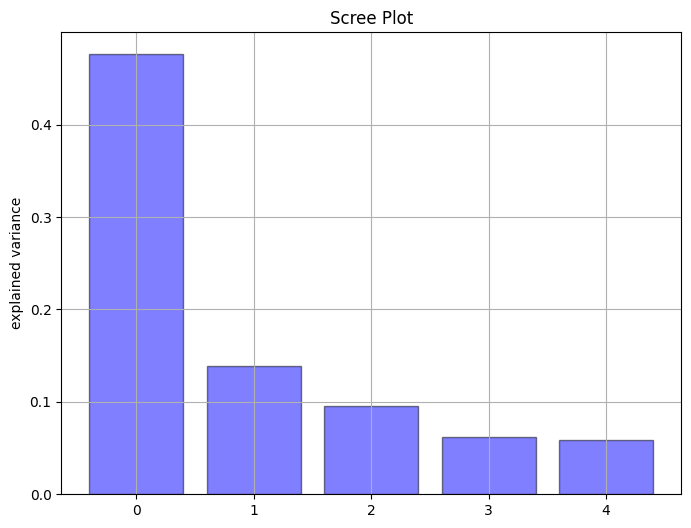

In [49]:
pca_model.plot(N_PCA_COMPONENTS)

In [50]:
pca_factors = pca_model.components(N_PCA_COMPONENTS)
x = pca_factors

In [51]:
pca_model.singular_values

array([3.03536773, 1.63781989, 1.3616901 , 1.09470787, 1.06725976,
       0.9999701 , 0.91969864, 0.7717528 , 0.74068072, 0.5334919 ])

In [52]:
pca_model.benchmark_test()

[ 3.90312782e-18  3.25260652e-18  4.11996826e-18  4.11996826e-18
  8.45677695e-18  1.67915811e-17  5.48877350e-18 -1.44198889e-17
  1.19262239e-17  2.16840434e-19]


In [53]:
mod = LinearRegressionModel(x=x, y=np.array(df[RIC]))

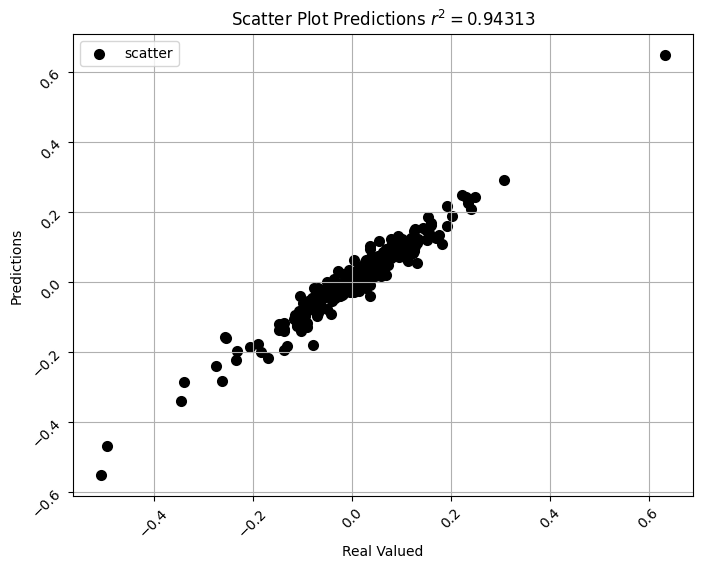

In [54]:
mod.plot()

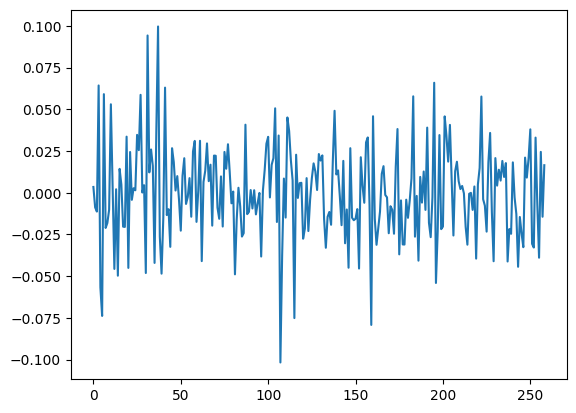

In [24]:
plt.plot(mod.residuals)

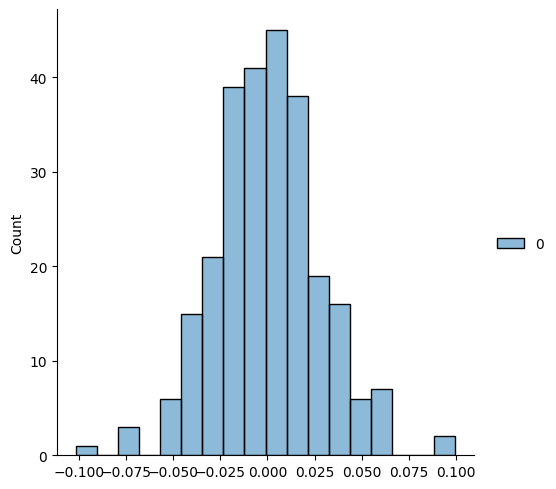

In [25]:
sns.displot(mod.residuals)

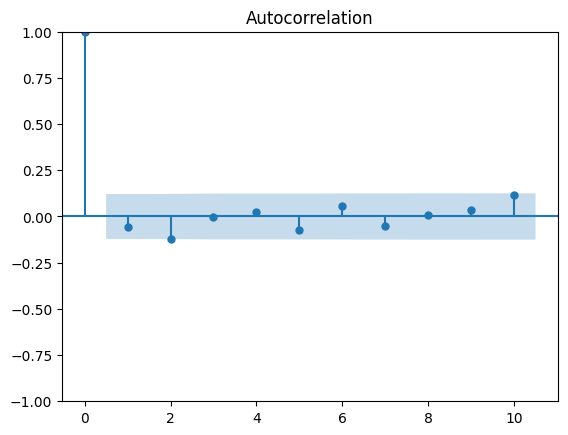

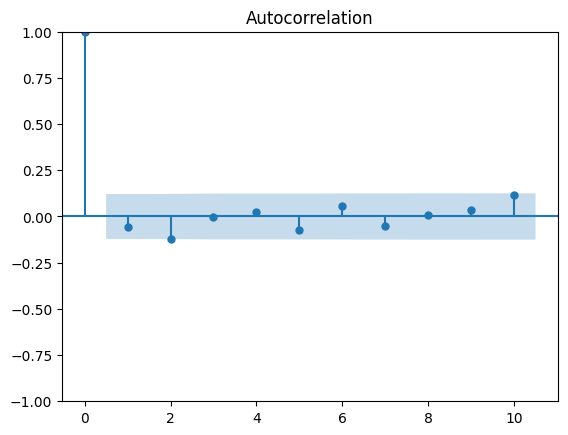

In [26]:
plot_acf(mod.residuals.flatten(), lags=10)

In [ ]:
## Rolling estimation

In [28]:
T = len(df)
period = 300
params = {}
eigenvals = {}
pca_factors = {}
for i in range(T):
    try:
        df_sliced = df.iloc[i:i+period, :]
        pca_model = PcaHandler(df_sliced)
        factors = pca_model.components(N_PCA_COMPONENTS)
        print(f'Lenght of data: {len(df_sliced)}')
        mod = LinearRegressionModel(x=factors, y=np.array(df_sliced[RIC]))
        params[i] = mod.beta.flatten()
        eigenvals[i] = pca_model.eig_vals.flatten()[:N_PCA_COMPONENTS]
        pca_factors[i] = factors.flatten()[:N_PCA_COMPONENTS]
    except:
        params[i] = np.repeat(np.nan, N_PCA_COMPONENTS)
        eigenvals[i] = np.repeat(np.nan, N_PCA_COMPONENTS)
        pca_factors[i] = np.repeat(np.nan, N_PCA_COMPONENTS)


Lenght of data: 259
Lenght of data: 258
Lenght of data: 257
Lenght of data: 256
Lenght of data: 255
Lenght of data: 254
Lenght of data: 253
Lenght of data: 252
Lenght of data: 251
Lenght of data: 250
Lenght of data: 249
Lenght of data: 248
Lenght of data: 247
Lenght of data: 246
Lenght of data: 245
Lenght of data: 244
Lenght of data: 243
Lenght of data: 242
Lenght of data: 241
Lenght of data: 240
Lenght of data: 239
Lenght of data: 238
Lenght of data: 237
Lenght of data: 236
Lenght of data: 235
Lenght of data: 234
Lenght of data: 233
Lenght of data: 232
Lenght of data: 231
Lenght of data: 230
Lenght of data: 229
Lenght of data: 228
Lenght of data: 227
Lenght of data: 226
Lenght of data: 225
Lenght of data: 224
Lenght of data: 223
Lenght of data: 222
Lenght of data: 221
Lenght of data: 220
Lenght of data: 219
Lenght of data: 218
Lenght of data: 217
Lenght of data: 216
Lenght of data: 215
Lenght of data: 214
Lenght of data: 213
Lenght of data: 212
Lenght of data: 211
Lenght of data: 210


In [29]:
rolling_betas = pd.DataFrame.from_dict(params, orient='index')
rolling_eig_vals = pd.DataFrame.from_dict(eigenvals, orient='index')
rolling_pcas = pd.DataFrame.from_dict(pca_factors, orient='index')

In [30]:
rolling_eig_vals

,0,1,2,3,4
0,0.035711,1.039711e-02,0.007187,4.644904e-03,4.414897e-03
1,0.035795,1.030641e-02,0.007158,4.658687e-03,4.429945e-03
2,0.035933,1.033059e-02,0.007076,4.675440e-03,4.431627e-03
3,0.035767,1.035396e-02,0.007075,4.651338e-03,4.448898e-03
4,0.035499,1.039421e-02,0.006859,4.649218e-03,4.071029e-03
...,...,...,...,...,...
254,0.023012,7.497534e-03,0.004913,1.662439e-03,3.374539e-34
255,0.030391,9.791236e-03,0.006256,1.467644e-34,NaN
256,NaN,NaN,NaN,NaN,NaN
257,0.036060,2.848481e-33,NaN,NaN,NaN


In [31]:
rolling_pcas

,0,1,2,3,4
0,-0.119703,1.882867e-01,1.226334e-01,3.574058e-02,-2.536204e-02
1,-0.018948,6.621446e-02,-1.712757e-01,2.057717e-02,6.595862e-02
2,-0.280198,-6.632686e-02,-8.699428e-02,-1.040477e-01,-4.777124e-03
3,0.326651,-1.244709e-02,-2.780440e-01,1.379396e-01,-3.540574e-01
4,-0.359504,-2.246075e-01,2.231978e-01,-1.032825e-01,-1.280195e-01
...,...,...,...,...,...
254,-0.027754,-2.604019e-02,3.150157e-02,6.912303e-02,-2.304774e-18
255,0.025953,1.426652e-01,3.054113e-02,-6.526887e-18,7.453704e-18
256,NaN,NaN,NaN,NaN,NaN
257,-0.134276,-9.172769e-18,4.960826e-18,-2.764475e-18,8.159232e-19


In [32]:
rolling_betas

,0,1,2,3,4,5
0,0.010239,-0.540731,3.048419e-01,1.701447e-01,5.216025e-01,3.065291e-01
1,0.009657,0.539238,-3.008255e-01,-1.779318e-01,-5.300988e-01,2.955141e-01
2,0.009569,-0.539309,3.040537e-01,1.695278e-01,5.359579e-01,-2.843847e-01
3,0.009294,-0.542355,2.992513e-01,1.632019e-01,5.480215e-01,-2.785398e-01
4,0.009741,0.544647,-2.998085e-01,-2.153368e-01,4.577466e-01,-5.629607e-01
...,...,...,...,...,...,...
254,0.078125,-0.562500,-5.000000e-01,5.000000e-01,-1.250000e-01,2.814750e+14
255,0.078125,0.000000,5.000000e-01,0.000000e+00,5.629500e+14,0.000000e+00
256,NaN,NaN,NaN,NaN,NaN,NaN
257,0.375000,-0.625000,-2.251800e+15,9.007199e+15,0.000000e+00,-9.007199e+15


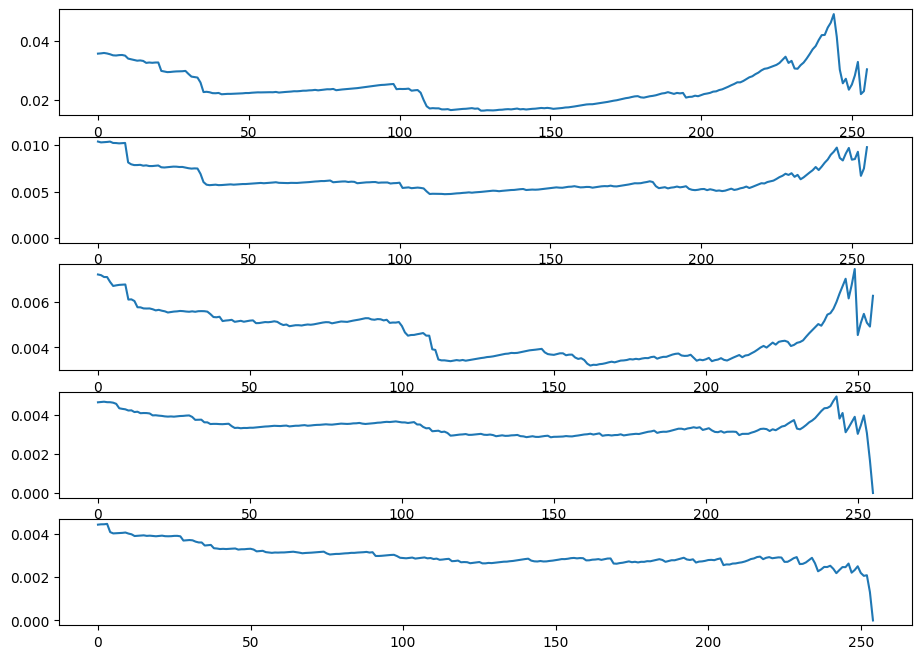

In [33]:
fig, axs = plt.subplots(N_PCA_COMPONENTS,1,figsize=(11,8))
for i in range(N_PCA_COMPONENTS):
    rolling_eig_vals.iloc[:,i].plot(ax=axs[i])
plt.show()

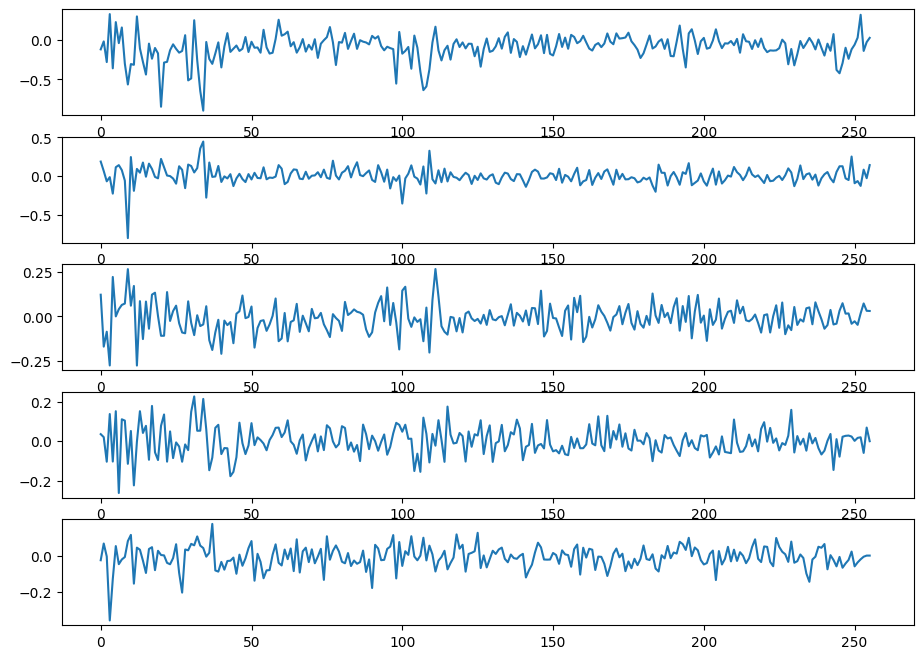

In [34]:
fig, axs = plt.subplots(N_PCA_COMPONENTS,1,figsize=(11,8))
for i in range(N_PCA_COMPONENTS):
    rolling_pcas.iloc[:,i].plot(ax=axs[i])
plt.show()

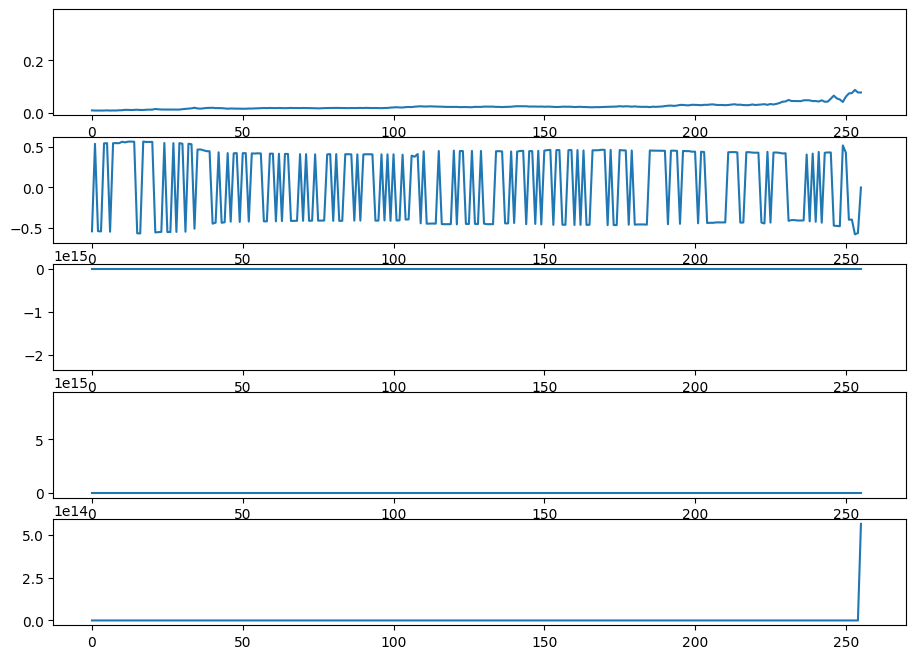

In [35]:
# when rolling period is about 120, there is crazy instability;
# when rolling period is about 300, there is OK instability; 2nd component is still unstable

fig, axs = plt.subplots(N_PCA_COMPONENTS,1,figsize=(11,8))
for i in range(N_PCA_COMPONENTS):
    rolling_betas.iloc[:,i].plot(ax=axs[i])
plt.show()

In [ ]:
rolling_betas.dropna()